In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
#import torchvision.models as models
import torchvision.transforms as transforms
from collections import defaultdict
history_dict = defaultdict(list)

In [2]:
# CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_data = CIFAR10(root='data', train=True, download=False, transform=None)
valid_data = CIFAR10(root='data', train=False, download=False, transform=None)
print('Dataset size: train={}, validation={}'.format(len(train_data), len(valid_data)))

Dataset size: train=50000, validation=10000


In [3]:
def preview(dataset):
    offset = 0
    fig, axs = plt.subplots(1, 10, figsize=(20,20))
    for i, ax in enumerate(axs):
        img = dataset[i+offset][0]
        target = dataset[i+offset][1]
        ax.imshow(img)
        if classes != None:
            label = classes[dataset[i+offset][1]]
            ax.set_title('{}: {}'.format(target, label))
        else:
            ax.set_title(target)
        ax.set_xticks([])
        ax.set_yticks([])
        offset = offset + 100
    plt.show()

TRAIN


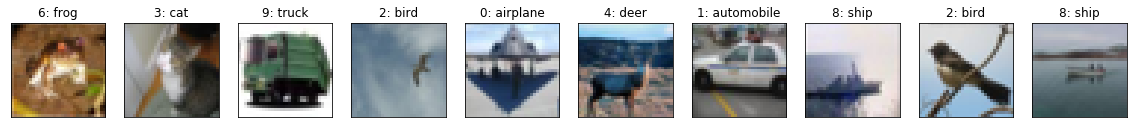

VALIDATION


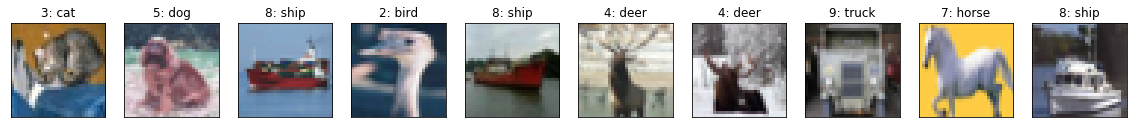

In [4]:
print('TRAIN')
preview(train_data)
print('VALIDATION')
preview(valid_data)

In [65]:
device = torch.device('cuda:0') #'cpu'
batch_size = 200
nb_epochs = 15
log_interval = 25
lr = 1e-2
drop_pct = 0.3

In [66]:
transformers = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_data = CIFAR10(root='data', train=True, download=False, transform=transformers)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

valid_data = CIFAR10(root='data', train=False, download=False, transform=transformers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [67]:
def train_epoch(model, device, train_loader, optimizer, criterion, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        history_dict['loss'].append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{:5}/{} ({:2.0f}%)\tLoss: {:.6f}'.
                  format(batch_idx * len(data),
                         len(train_loader.dataset),
                         100. * batch_idx / len(train_loader),
                         loss.item()))


def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Accuracy: {}/{} ({:.2f}%)\n'.
          format(correct, len(test_loader.dataset), accuracy))
          #format(test_loss, correct, len(test_loader.dataset), accuracy))
    return accuracy

def train(model, optimizer, scheduler, criterion, train_loader, test_loader, device, lr, nb_epochs=3, log_interval=100):
    for epoch in range(1, nb_epochs + 1):
        scheduler.step()
        
        print('\n*** Training Epoch {} - LR {} ***'.format(epoch, scheduler.get_lr()))
        
        train_epoch(model, device, train_loader, optimizer, criterion, log_interval)
        
        print('\n*** Validating Epoch {} ***'.format(epoch))
        
        acc = test(model, device, criterion, test_loader)
        
        history_dict['val_acc'].append(acc)
    
    return acc

In [68]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(32)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=drop_pct, inplace=True),
            nn.BatchNorm2d(128)
        )
        self.fc1 = nn.Linear(4*4*128, 512)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [69]:
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)

In [70]:
history_dict = defaultdict(list)
acc = train(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


*** Training Epoch 1 - LR [0.01] ***
    0/50000 ( 0%)	Loss: 3.533860
 5000/50000 (10%)	Loss: 4.474675
10000/50000 (20%)	Loss: 2.182159
15000/50000 (30%)	Loss: 1.945908
20000/50000 (40%)	Loss: 1.656103
25000/50000 (50%)	Loss: 1.706379
30000/50000 (60%)	Loss: 1.851955
35000/50000 (70%)	Loss: 2.089993
40000/50000 (80%)	Loss: 1.758926
45000/50000 (90%)	Loss: 1.664861

*** Validating Epoch 1 ***
Accuracy: 4541/10000 (45.41%)


*** Training Epoch 2 - LR [0.01] ***
    0/50000 ( 0%)	Loss: 1.551198
 5000/50000 (10%)	Loss: 1.585439
10000/50000 (20%)	Loss: 1.681553
15000/50000 (30%)	Loss: 1.637264
20000/50000 (40%)	Loss: 1.752810
25000/50000 (50%)	Loss: 1.407279
30000/50000 (60%)	Loss: 1.276248
35000/50000 (70%)	Loss: 1.343399
40000/50000 (80%)	Loss: 1.283614
45000/50000 (90%)	Loss: 1.206718

*** Validating Epoch 2 ***
Accuracy: 5759/10000 (57.59%)


*** Training Epoch 3 - LR [0.01] ***
    0/50000 ( 0%)	Loss: 1.211228
 5000/50000 (10%)	Loss: 1.205039
10000/50000 (20%)	Loss: 1.133087
15000/500

In [71]:
def plot_curves(loss_values, val_acc):
    '''
        Function to plot training loss 
        and validation accuracy
    '''
    fig, ax = plt.subplots(2, 1, figsize=(15,5))
    ax[0].set_title('Training Loss')
    ax[0].plot(loss_values)
    ax[0].set_title('Loss')
    ax[0].set_xticks([])
    ax[1].set_title('Validation Accuracy')
    ax[1].plot(val_acc)
    ax[1].set_xticks([])


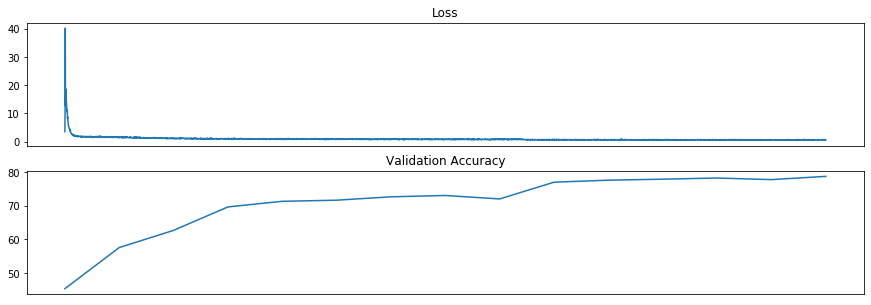

In [72]:
plot_curves(history_dict['loss'], history_dict['val_acc'])